<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/deeplearning.ai/tf/c4_week1_lesson2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequences, Time Series and Predictions - Week 1 Lesson 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras

In [2]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

## Trend and Seasonality

In [5]:
def trend(time, slope=0):
  return slope * time

Let's create a time series that just trends upward:

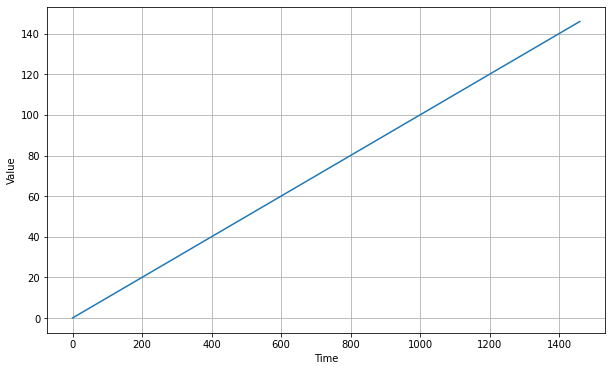

In [6]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)

Now let's generate a time series with a ***seasonal pattern***:

In [10]:
def seasonal_pattern(season_time):
  '''
  Just an arbitrary pattern, you can change it if you wish
  '''
  return np.where(
      season_time < 0.4,
      np.cos(season_time * 2 * np.pi),
      1 / np.exp(3 * season_time)
  )

def seasonality(time, period, amplitude=1, phase=0):
  '''
  Repeats the same pattern at each period
  '''
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

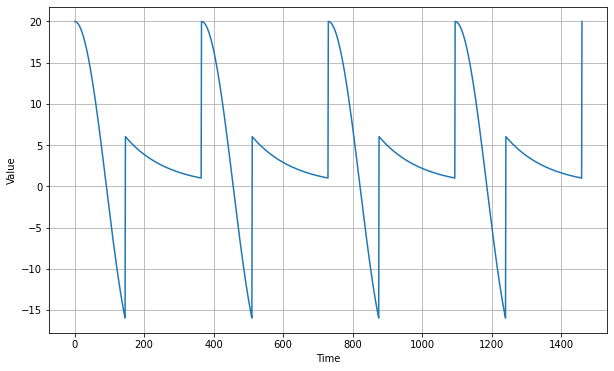

In [14]:
baseline = 10
amplitude = 20
series = seasonality(time, period=365, amplitude=amplitude)
plt.figure(figsize=(10, 6))
plot_series(time, series)

Now let's create a time series with both trend and seasonality:

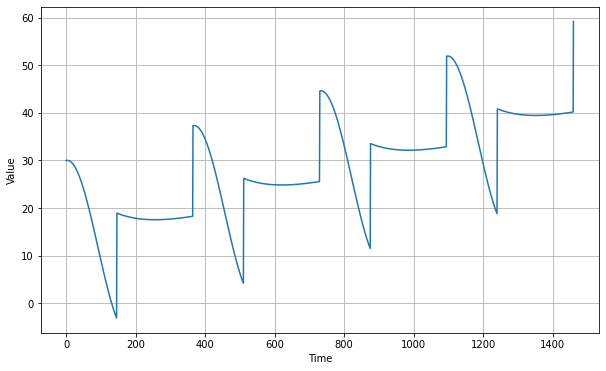

In [19]:
slope = 0.02
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)

## Noise

In practive few real-life time series have such a smooth signal. They usually have some noise, and signal-to-noise ratio can sometimes be very low. Let's generate some white noise:

In [20]:
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

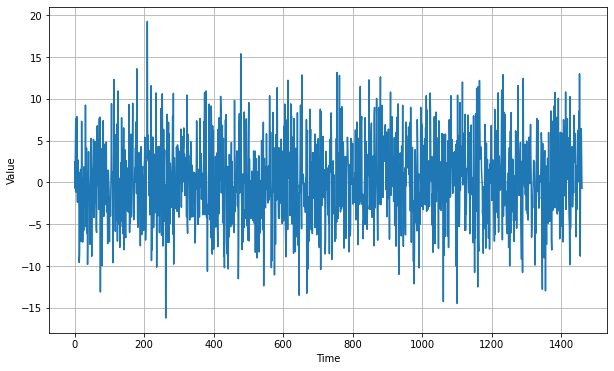

In [21]:
noise_level = 5
noise = white_noise(time, noise_level=5, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)

Now let's add this white noise to the series:

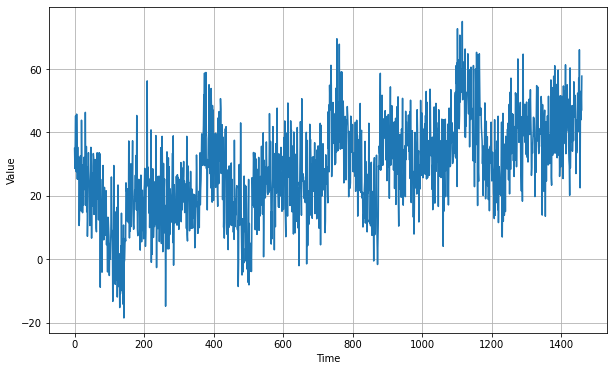

In [23]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)

At this point it look realistic enough for now. Let's tru to forecast it. We will split it into two periods: the training period and the validation period (in many cases, you would also want to have a test period). The split be at time step 1000.

In [24]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [27]:
def autocorrelation1(time, amplitude, seed=None):
  rnd = np.random.RandomState(seed)
  φ1 = 0.5
  φ2 = -0.1
  ar = rnd.randn(len(time) + 50)
  ar[:50] = 100
  for step in range(50, len(time) + 50):
    ar[step] += φ1 * ar[step - 50]
    ar[step] += φ2 * ar[step - 33]
  return ar[50:] * amplitude

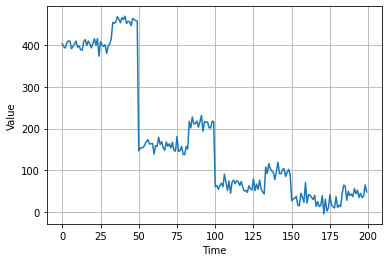

In [28]:
series = autocorrelation1(time, 10, seed=42)
plot_series(time[:200], series[:200])

In [33]:
def autocorrelation2(time, amplitude, seed=None):
  rnd = np.random.RandomState(seed)
  φ = 0.8
  ar = rnd.randn(len(time) + 1)
  for step in range(1, len(time) + 1):
    ar[step] += φ * ar[step - 1]
  return ar[1:] * amplitude

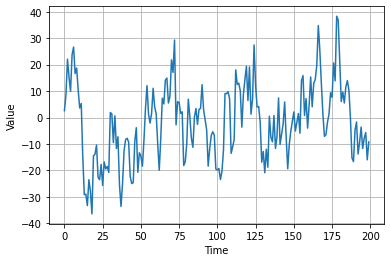

In [35]:
series = autocorrelation2(time, 10, seed=42)
plot_series(time[:200], series[:200])

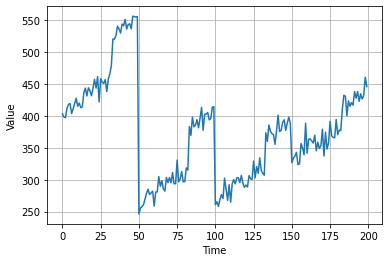

In [37]:
series = autocorrelation1(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])

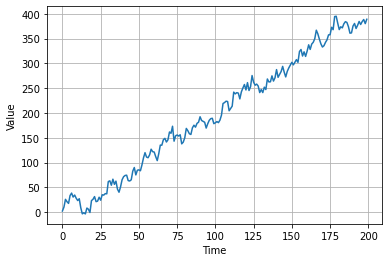

In [38]:
series = autocorrelation2(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])

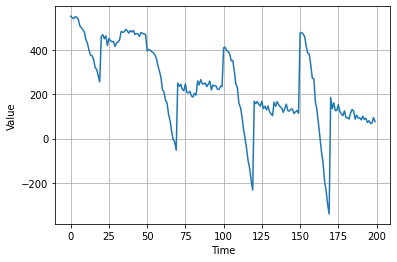

In [39]:
series = autocorrelation1(time, 10, seed=42) + seasonality(time, period=50, amplitude=150 + trend(time, 2))
plot_series(time[:200], series[:200])

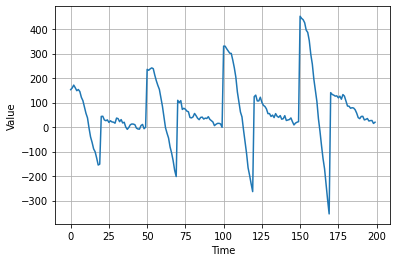

In [40]:
series = autocorrelation2(time, 10, seed=42) + seasonality(time, period=50, amplitude=150 + trend(time, 2))
plot_series(time[:200], series[:200])

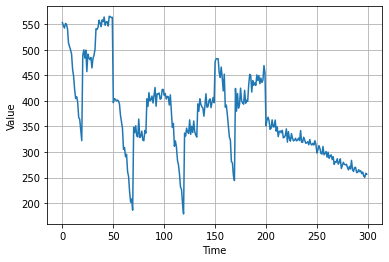

In [41]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
#series += noise(time, 30)
plot_series(time[:300], series[:300])

In [42]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series    

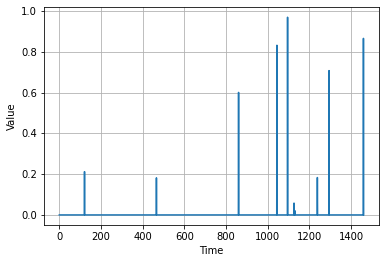

In [43]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [44]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
              ar[step] += φ * ar[step - lag]
    return ar

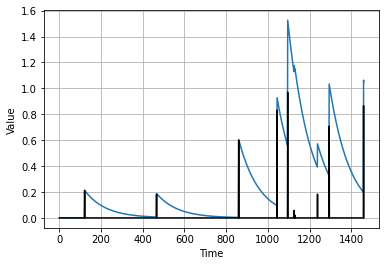

In [45]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

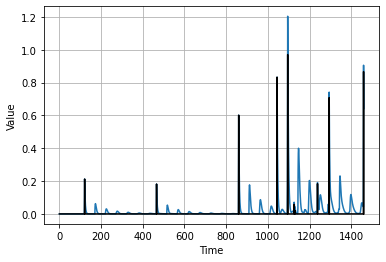

In [48]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-");

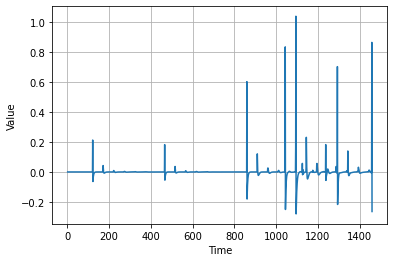

In [49]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

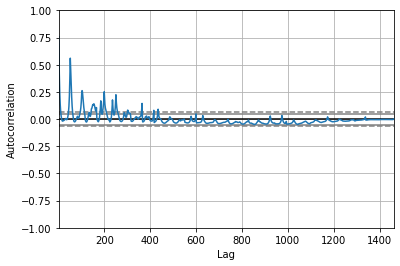

In [51]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series);

In [55]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.428
Method:                       css-mle   S.D. of innovations              0.053
Date:                Tue, 10 Nov 2020   AIC                          -4432.855
Time:                        05:18:07   BIC                          -4395.852
Sample:                             1   HQIC                         -4419.052
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.384      0.701      -0.001       0.002
ar.L1.D.y     -0.1235      0.026     -4.714      0.000      -0.175      -0.072
ar.L2.D.y     -0.1254      0.029     -4.333      0.000      -0.182      -0.069
ar.L3.D.y     -0.1089      0.029     -3.759      0.000      -0.166      -0.052
ar.L4.D.y     -0.0914      0.029     -3.162      0.002      -0.148      -0.035
ar.L5.D.y     -0.0774      0.029     -2.675      0.008      -0.134      -0.021
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0145           -1.1311j            1.5194           -0.1336
AR.2            1.0145           +1.1311j            1.5194            0.1336
AR.3           -1.8173           -0.0000j            1.8173           -0.5000
AR.4           -0.6967           -1.6113j            1.7554           -0.3150
AR.5           -0.6967           +1.6113j            1.7554            0.3150
-----------------------------------------------------------------------------
"""